##Importing Libararies

In [ ]:
import cv2
import os
import numpy as np
import PIL as Image
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

##Preparing Dataset

In [ ]:
highres_images_dir = '/content/drive/MyDrive/Project/GANs/Sandstone_high_low_res/higres'
lowres_images_dir = '/content/drive/MyDrive/Project/GANs/Sandstone_high_low_res/lowres'

In [ ]:
def get_data(highres_images_dir, lowres_images_dir):
  highres_images_path_list = [os.path.join(highres_images_dir, x) for x in sorted(os.listdir(highres_images_dir))]
  lowres_images_path_list = [os.path.join(lowres_images_dir, x) for x in sorted(os.listdir(lowres_images_dir))]
  return highres_images_path_list, lowres_images_path_list

In [ ]:
highres_images_path_list, lowres_images_path_list = get_data(highres_images_dir, lowres_images_dir)

##Visualizing Dataset

In [ ]:
def show_image(image, title='', cmap = None):
  plt.imshow(image, cmap=cmap, alpha=1)
  if title is not None:
    plt.title(title)
  plt.axis('off')

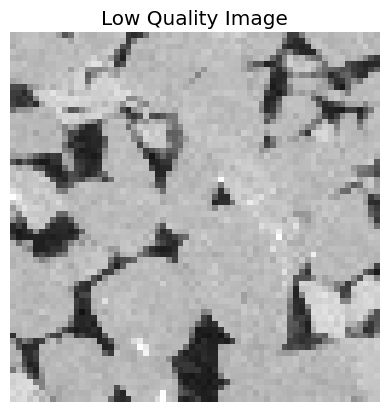

In [ ]:
lowres_image = cv2.imread(lowres_images_path_list[5])
show_image(lowres_image, 'Low Quality Image')

In [ ]:
print(f'Shape Of Low Resolution Image:',lowres_image.shape)

Shape Of Low Resolution Image: (64, 64, 3)


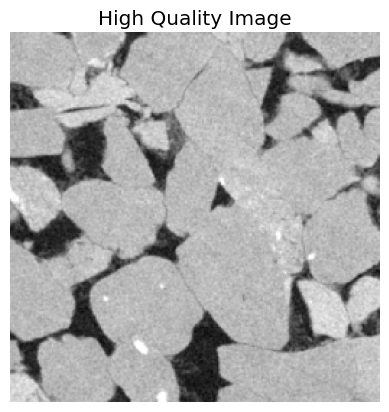

In [ ]:
highres_image = cv2.imread(highres_images_path_list[5])
show_image(highres_image, 'High Quality Image')

In [ ]:
print(f'Shape Of High Resolution Image:',highres_image.shape)

Shape Of High Resolution Image: (256, 256, 3)


In [ ]:
def display_dataset(highres_images_path_list, lowres_images_path_list):
  plt.figure(figsize=(10,9))
  id = 0
  for i in tqdm(range(12)):
    plt.subplot(3,4,i+1)
    if i%2==0:
      highres_image_path = highres_images_path_list[id]
      highres_image = cv2.imread(highres_image_path)
      show_image(highres_image, cmap='gray')

    elif i%2==1:
      lowres_image_path = lowres_images_path_list[id]
      lowres_image = cv2.imread(lowres_image_path)
      show_image(lowres_image, cmap='gray')      
      id = id + 1
  plt.tight_layout()
  plt.suptitle('Dataset', size=16)
  plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

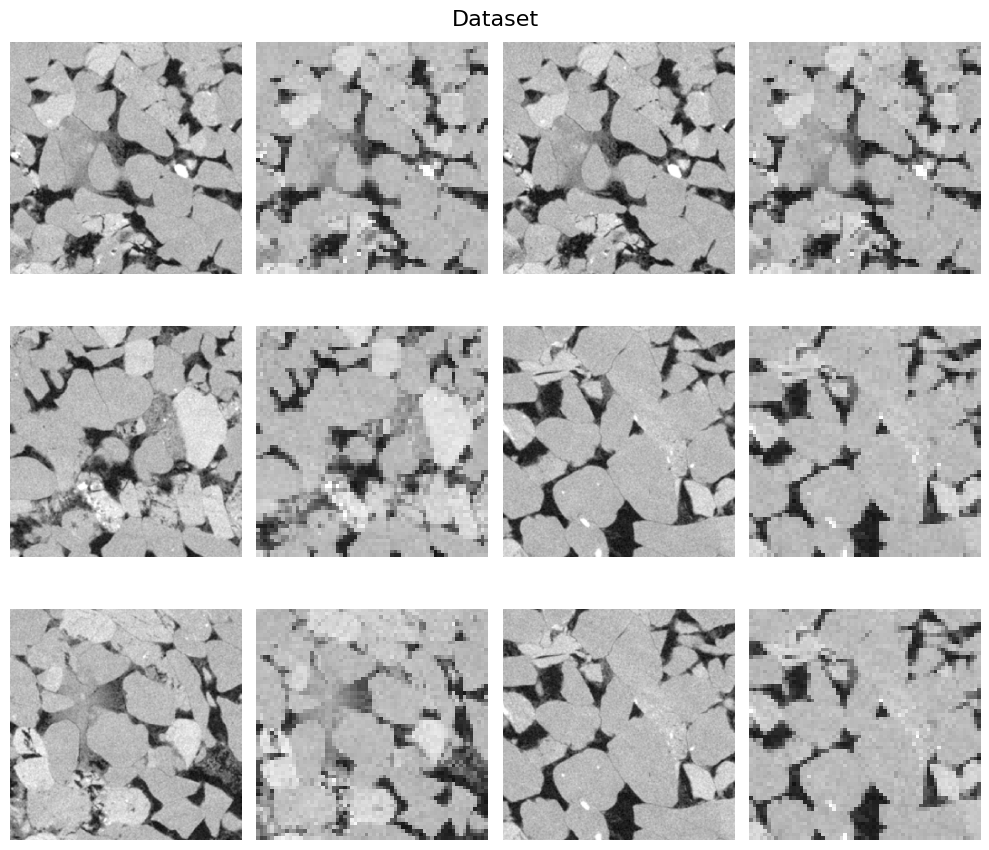

In [ ]:
display_dataset(highres_images_path_list, lowres_images_path_list)

##Loading Data

In [ ]:
def build_data(lowres_images_path_list, highres_images_path_list):
  X = np.zeros((len(lowres_images_path_list), 64, 64, 3), dtype=np.uint8).astype(np.float32)
  y = np.zeros((len(highres_images_path_list), 256, 256, 3), dtype=np.uint8).astype(np.float32)

  for i, (lowres_image_path, highres_image_path) in tqdm(enumerate(zip(lowres_images_path_list, highres_images_path_list))):
    lowres_img = cv2.imread(lowres_image_path)
    lowres_img = lowres_img/255.
    X[i] = lowres_img

    highres_img = cv2.imread(highres_image_path)
    highres_img = highres_img/255.
    y[i] = highres_img

  return X, y  

In [ ]:
X, y = build_data(lowres_images_path_list, highres_images_path_list)

0it [00:00, ?it/s]

In [ ]:
print('Input Data Shape & Size:',X.shape)

Input Data Shape & Size: (300, 64, 64, 3)


In [ ]:
print('Input Data Shape & Size:',y.shape)

Input Data Shape & Size: (300, 256, 256, 3)


##Importing Dependencies

In [ ]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from tensorflow.keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import plot_model

##Building Attention U-Net Model

In [ ]:
def resnet_block(ip):   
  res_model = Conv2D(64, (3,3), padding = "same")(ip)
  res_model = BatchNormalization(momentum = 0.5)(res_model)
  res_model = PReLU(shared_axes = [1,2])(res_model)
  
  res_model = Conv2D(64, (3,3), padding = "same")(res_model)
  res_model = BatchNormalization(momentum = 0.5)(res_model)
  
  return add([ip,res_model])

In [ ]:
def upscale_block(ip): 
  up_model = Conv2D(256, (3,3), padding="same")(ip)
  up_model = UpSampling2D(size = 2 )(up_model)
  up_model = PReLU(shared_axes=[1,2])(up_model)
  
  return up_model

In [ ]:
def create_generator(gen_ip, num_res_block):
  layers = Conv2D(64, (9,9), padding="same")(gen_ip)
  layers = PReLU(shared_axes=[1,2])(layers)

  temp = layers

  for i in range(num_res_block):
      layers = resnet_block(layers)

  layers = Conv2D(64, (3,3), padding="same")(layers)
  layers = BatchNormalization(momentum=0.5)(layers)
  layers = add([layers,temp])

  layers = upscale_block(layers)
  layers = upscale_block(layers)

  op = Conv2D(3, (9,9), padding="same")(layers)

  return Model(inputs=gen_ip, outputs=op, name='Generator')

In [ ]:
def discriminator_block(ip, filters, strides=1, bn=True):
  disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
  
  if bn:
      disc_model = BatchNormalization( momentum=0.8 )(disc_model)
  
  disc_model = LeakyReLU( alpha=0.2 )(disc_model)
  
  return disc_model

In [ ]:
def create_discriminator(disc_ip):
  df = 64
  
  d1 = discriminator_block(disc_ip, df, bn=False)
  d2 = discriminator_block(d1, df, strides=2)
  d3 = discriminator_block(d2, df*2)
  d4 = discriminator_block(d3, df*2, strides=2)
  d5 = discriminator_block(d4, df*4)
  d6 = discriminator_block(d5, df*4, strides=2)
  d7 = discriminator_block(d6, df*8)
  d8 = discriminator_block(d7, df*8, strides=2)

  d8_5 = Flatten()(d8)
  d9 = Dense(df*16)(d8_5)
  d10 = LeakyReLU(alpha=0.2)(d9)
  validity = Dense(1, activation='sigmoid')(d10)

  return Model(disc_ip, validity, name='Discriminator')

In [ ]:
def build_vgg(hr_shape):
  vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
  return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output, name='VGG19')

In [ ]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
  gen_img = gen_model(lr_ip)
  gen_features = vgg(gen_img)
  disc_model.trainable = False
  validity = disc_model(gen_img)
  
  return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features], name='Combine')

##Spliting Dataset Into Train & Test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
lowres_train, lowres_test, highres_train, highres_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Preparing Inputs

In [ ]:
highres_shape = (highres_train.shape[1], highres_train.shape[2], highres_train.shape[3])
lowres_shape = (lowres_train.shape[1], lowres_train.shape[2], lowres_train.shape[3])

In [ ]:
lowres_ip = Input(shape=lowres_shape)
highres_ip = Input(shape=highres_shape)

## Instantiating Generator

In [ ]:
generator = create_generator(lowres_ip, num_res_block = 16)
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_119 (Conv2D)            (None, 64, 64, 64)   15616       ['input_10[0][0]']               
                                                                                                  
 p_re_lu_57 (PReLU)             (None, 64, 64, 64)   64          ['conv2d_119[0][0]']             
                                                                                                  
 conv2d_120 (Conv2D)            (None, 64, 64, 64)   36928       ['p_re_lu_57[0][0]']             
                                                                                          

##Visualizing Generator

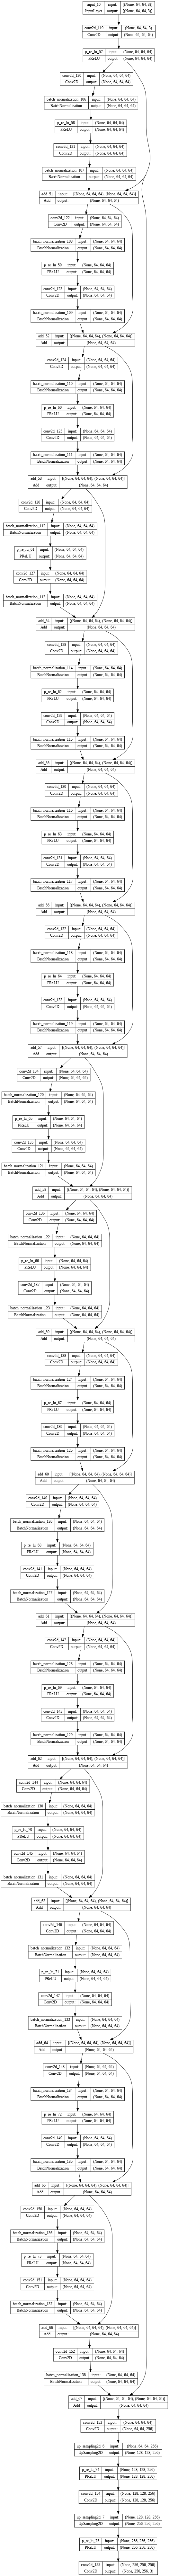

In [ ]:
plot_model(generator, show_shapes=True, show_layer_names=True, dpi=64)

##Instantiating Discriminator

In [ ]:
discriminator = create_discriminator(highres_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_156 (Conv2D)         (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 256, 256, 64)      0         
                                                                 
 conv2d_157 (Conv2D)         (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_139 (Ba  (None, 128, 128, 64)     256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                     

##Visualizing Discriminator

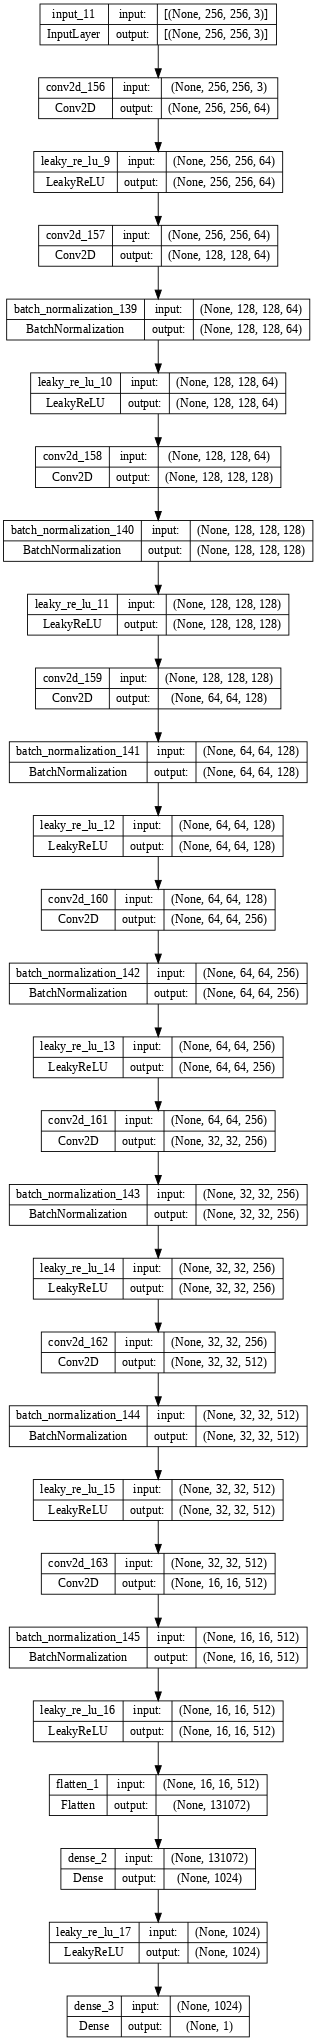

In [ ]:
plot_model(discriminator, show_shapes=True, show_layer_names=True, dpi=64)

##Instantiating VGG19

In [ ]:
vgg = build_vgg((256,256,3))
vgg.trainable = False
print(vgg.summary())

Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

##Visualizing VGG19

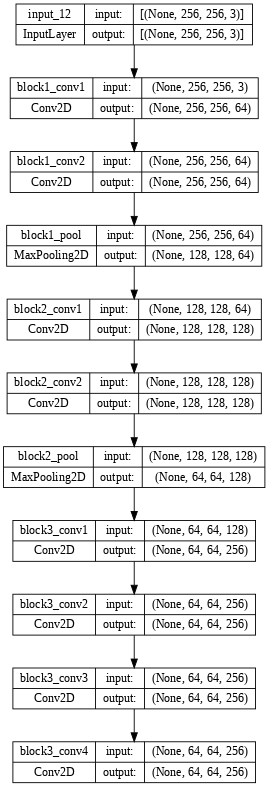

In [ ]:
plot_model(vgg, show_shapes=True, show_layer_names=True, dpi=64)

##Building Combine Model i.e Attention U-Net

In [ ]:
gan_model = create_comb(generator, discriminator, vgg, lowres_ip, highres_ip)
gan_model.summary()

Model: "Combine"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Generator (Functional)         (None, 256, 256, 3)  2044291     ['input_10[0][0]']               
                                                                                                  
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Discriminator (Functional)     (None, 1)            138912577   ['Generator[6][0]']        

##Visualizing Combine Model i.e Attention U-Net

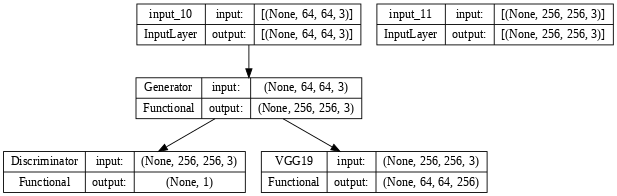

In [ ]:
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=64)

##Compileing Model

In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")

##Preparing Batch

In [ ]:
batch_size = 1  
train_lowres_batches = []
train_highres_batches = []
for it in range(int(highres_train.shape[0] / batch_size)):
  start_idx = it * batch_size
  end_idx = start_idx + batch_size
  train_highres_batches.append(highres_train[start_idx:end_idx])
  train_lowres_batches.append(lowres_train[start_idx:end_idx])

##Training The Model

In [ ]:
epochs = 30
per_epoch_g_losses = []
per_epoch_d_losses = []

for e in tqdm(range(epochs)):
  fake_label = np.zeros((batch_size, 1)) 
  real_label = np.ones((batch_size,1)) 
  
  g_losses = []
  d_losses = []

  for b in tqdm(range(len(train_highres_batches))):
    lr_imgs = train_lowres_batches[b] 
    hr_imgs = train_highres_batches[b] 
    
    fake_imgs = generator.predict_on_batch(lr_imgs) 
    
    #First, train the discriminator on fake and real HR images. 
    discriminator.trainable = True
    d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
    d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
    
    #Now, train the generator by fixing discriminator as non-trainable
    discriminator.trainable = False
    
    #Average the discriminator loss, just for reporting purposes. 
    d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
    
    #Extract VGG features, to be used towards calculating loss
    image_features = vgg.predict(hr_imgs)
  
    #Train the generator via GAN. 
    #Remember that we have 2 losses, adversarial loss and content (VGG) loss
    g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
    
    #Save losses to a list so we can average and report. 
    d_losses.append(d_loss)
    g_losses.append(g_loss)
      
  #Convert the list of losses to an array to make it easy to average    
  g_losses = np.array(g_losses)
  d_losses = np.array(d_losses)
  
  #Calculate the average losses for generator and discriminator
  g_loss = np.sum(g_losses, axis=0) / len(g_losses)
  d_loss = np.sum(d_losses, axis=0) / len(d_losses)

  per_epoch_g_losses.append(g_loss)
  per_epoch_d_losses.append(d_loss)
  
  #Report the progress during training. 
  print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

  if (e+1) % 10 == 0:
    #Save the generator after every n epochs (Usually 10 epochs)
    generator.save("gen_e_"+ str(e+1) +".h5")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 1 g_loss: 14.849566376209259 d_loss: [1.59759732 0.95833333]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
epoch: 2 g_loss: 11.653726442654927 d_loss: [1.87793141 0.96666667]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 3 g_loss: 11.166521282990773 d_loss: [0.96774399 0.97708333]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 4 g_loss: 10.778479679425557 d_loss: [1.2780554 0.975    ]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 5 g_loss: 10.366412925720216 d_loss: [1.90844655 0.9625    ]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
epoch: 6 g_loss: 436.8833624800046 d_loss: [2.72232185 0.94166667]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 7 g_loss: 85.02543918291728 d_loss: [1.38788182 0.97916667]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 8 g_loss: 34.58626418908437 d_loss: [0.29903907 0.98958333]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 9 g_loss: 25.078797761599223 d_loss: [0.00761894 0.99791667]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


epoch: 10 g_loss: 22.936544847488403 d_loss: [3.34785273e-18 1.00000000e+00]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 11 g_loss: 21.97011740207672 d_loss: [3.27090928e-13 1.00000000e+00]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
epoch: 12 g_loss: 21.242818069458007 d_loss: [0.62977992 0.98958333]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 13 g_loss: 20.96820281346639 d_loss: [0.64228492 0.98958333]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
epoch: 14 g_loss: 20.209150433540344 d_loss: [3.24339131e-10 1.00000000e+00]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 15 g_loss: 19.984124938646953 d_loss: [1.17727348 0.9875    ]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
epoch: 16 g_loss: 19.64422788619995 d_loss: [0. 1.]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 17 g_loss: 19.326359220345815 d_loss: [3.53056839e-31 1.00000000e+00]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 18 g_loss: 19.03839916785558 d_loss: [0.68528369 0.99166667]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
epoch: 19 g_loss: 18.74958812793096 d_loss: [0. 1.]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


epoch: 20 g_loss: 18.722763097286226 d_loss: [0. 1.]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 21 g_loss: 18.169969630241393 d_loss: [4.28933572 0.98541667]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 22 g_loss: 17.59596061706543 d_loss: [2.38680785 0.98541667]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
epoch: 23 g_loss: 17.164865012963613 d_loss: [3.18687938 0.98125   ]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 24 g_loss: 16.580426077047985 d_loss: [1.11730634 0.98541667]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 25 g_loss: 16.009040101369223 d_loss: [5.54540133 0.94791667]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
epoch: 26 g_loss: 14.936128199100494 d_loss: [3.38531466 0.95416667]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
epoch: 27 g_loss: 14.09557489156723 d_loss: [1.33745496 0.96458333]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
epoch: 28 g_loss: 13.466421862443289 d_loss: [1.4522064  0.97083333]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
epoch: 29 g_loss: 13.522754096984864 d_loss: [0.62708632 0.98333333]


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


epoch: 30 g_loss: 13.677332631746928 d_loss: [0.46578926 0.98958333]


##Generator Loss Visualization

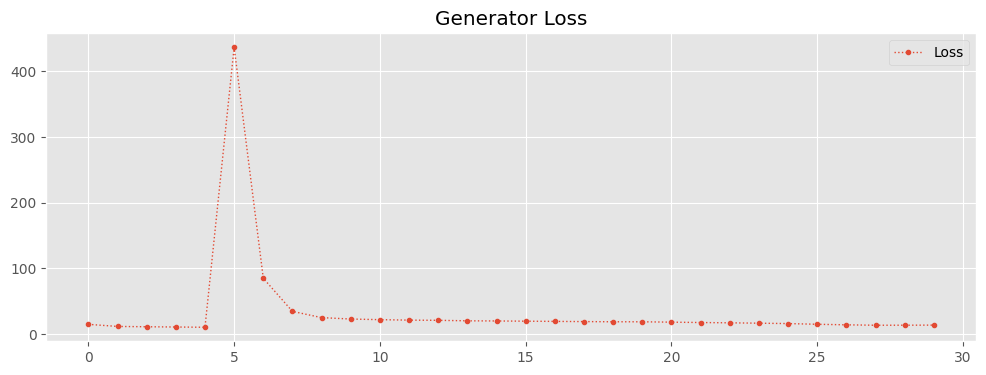

In [ ]:
plt.figure(figsize=(12,4))
plt.title("Generator Loss")
plt.plot(per_epoch_g_losses, ".:", label="Loss", linewidth=1)
plt.legend()
plt.show()

In [ ]:
d_loss = []
for value in tqdm(per_epoch_d_losses):
  d_loss.append(np.sum(value) / len(value))

  0%|          | 0/30 [00:00<?, ?it/s]

##Discriminator Loss Visualization

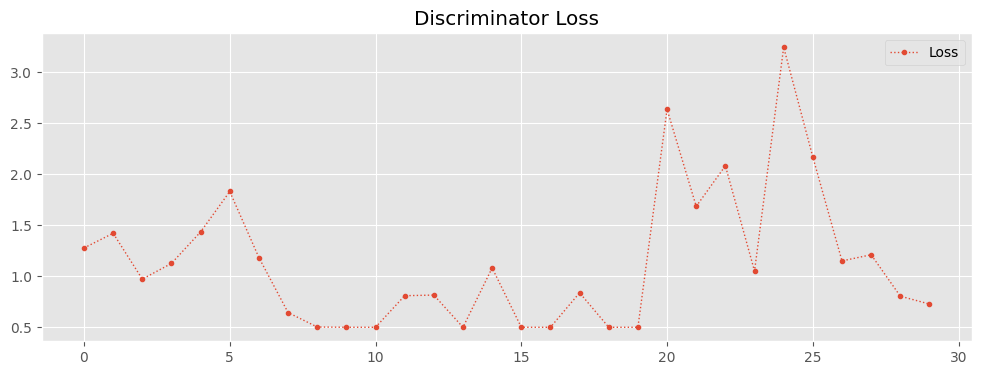

In [ ]:
plt.figure(figsize=(12,4))
plt.title("Discriminator Loss")
plt.plot(d_loss, ".:", label="Loss", linewidth=1)
plt.legend()
plt.show()

##Attention U-Net Prediction

In [ ]:
from keras.models import load_model
from numpy.random import randint

  0%|          | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


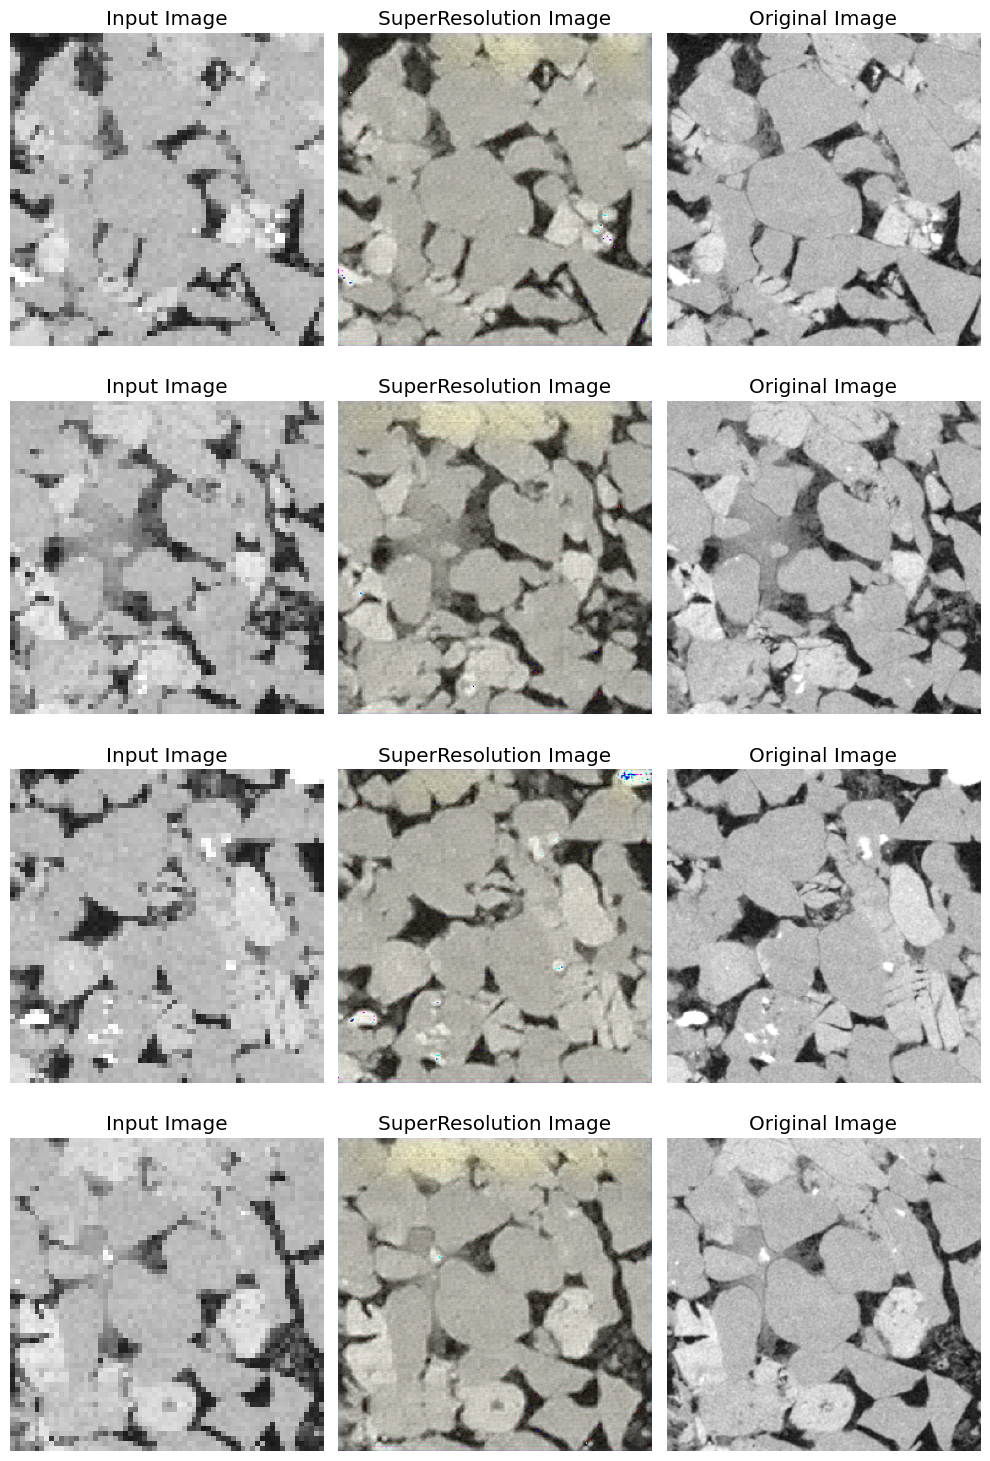

In [ ]:
[X1, X2] = [lowres_test, highres_test]

plt.figure(figsize=(10,15))
id = randint(0, len(X1), 1)
n = 0
pred_out = None
for i in tqdm(range(12)):
  plt.subplot(4,3,i+1)
  
  if n==0:
    show_image((X1[id[0]] * 255).astype(np.uint8), title='Input Image')
    
    n+=1
  elif n==1:
    gen_image = generator.predict(X1[id])
    show_image((gen_image[0] * 255).astype(np.uint8), title='SuperResolution Image')
    
    n+=1
  elif n==2:
    show_image((X2[id[0]] * 255).astype(np.uint8), title='Original Image')  
    n=0
    id = randint(0, len(X1), 1)
plt.tight_layout()
plt.show()